Морфологический анализ <br/>
Домашнее задание 5 <br/>
**Голев Александр 135М**

# Исследовать помехозащищенность морфологических методов идентификации
на примере задачи идентификации цифр 0, 1, . . . , 9 по их изображениям, пораженным случайным попиксельно независимым аддитивным шумом.

**Варианты построения проекторов Πi:**
- После бинаризации изображений цифр Πi строятся как проекторы на формы изображений с двумя областями постоянной яркости.
- Для генерации шума используется дискретное равномерное распределение сдвумя равновероятными значениями отклонений, σ и −σ.

Построить график зависимости частоты ошибок идентификации от корня дисперсии шума σ. 

Для наибольшей дисперсии шума также получить матрицу путаницы.

In [120]:
import cv2
from IPython.display import Image, display
import matplotlib.pyplot as plt
import numpy as np
import random

In [121]:
# Загружаем изображение
samples = []
samples_bin = []
for i in range(10):
    image = cv2.imread(f'samples/c_{i}.png')
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    samples.append(gray_image)
    _, image_bin = cv2.threshold(gray_image, 128, 255, cv2.THRESH_BINARY)
    samples_bin.append(image_bin)


In [122]:
def showOneLine(images, texts, dim = 3):
    plt.figure(figsize=(28, 16))
    length = len(images)
    for i, (image, text) in enumerate(zip(images, texts)):
        plt.subplot(length//dim+1, dim, i+1)
        plt.title(text)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()
    

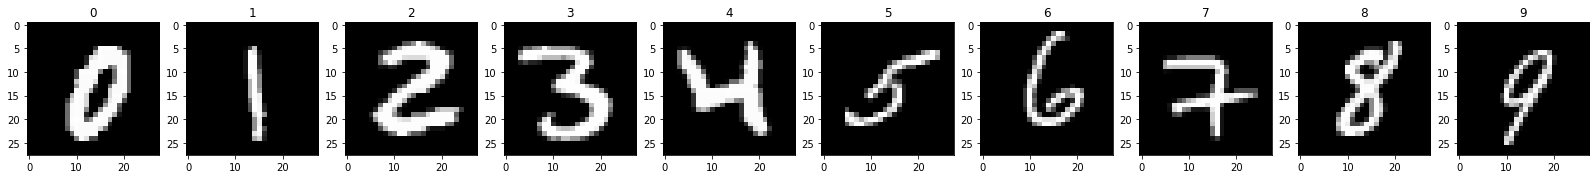

In [123]:
showOneLine(samples,[str(x) for x in range(10)],dim = 10)

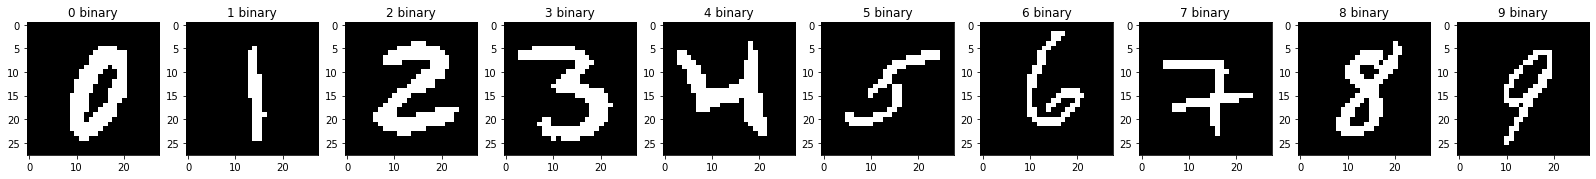

In [124]:
showOneLine(samples_bin,[str(x)+' binary' for x in range(10)],dim = 10)

## Выборка
Выборку генерируем так, чтобы в ней было одинаковое число изображений каждой цифры, например, по 100 изображений каждой цифры.

### Генерация шума

In [125]:
def addNoise(img, abs_sigma):
    noise = np.random.choice([-abs_sigma, abs_sigma], img.shape) ###!!!!!!!!!!!!!!!!!!!!!!!!!!
    return np.clip(img +  noise, 0, 255).astype(np.uint8)


Проверим

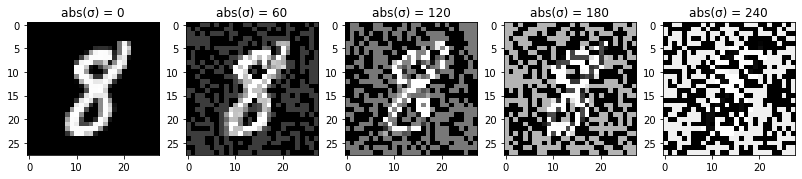

In [150]:
noise_examples = []
digit_samle = samples[8]  # Выберите случайную цифру из исходных
tmp_mlt = 60
for i in range(5):
    sigma = i*tmp_mlt  # Отклонение
    noise_examples.append( addNoise(digit_samle,abs_sigma = i*tmp_mlt))
    
showOneLine(noise_examples,[f'abs(σ) = {x*tmp_mlt}' for x in range(10)], dim = 10)


### Генерация большой выборки

In [127]:
def genNoises(img, abs_sigma, length = 100):
    noises = []
    for i in range(length):
        noises.append( addNoise(img,abs_sigma))
    return noises

Пример: выборка длинной 5 с отклонением 125

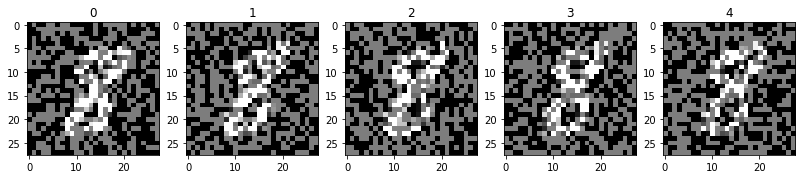

In [151]:
tmp = genNoises(digit_samle, 125, length = 5)
showOneLine(tmp,[str(x) for x in range(len(tmp))], dim = 10)


## Определение цифры

In [129]:
def projection(g,f):
    p = g.copy()
    p[f==0] = np.ma.array(g,mask=f).mean()
    p[f==255] = np.ma.array(g,mask=(255-f)).mean()
    return p

In [130]:
I = np.ones(samples[0].shape,dtype=np.uint8)

def findDigit(image, projection):
    min_diff = float('inf')
    E = np.ones(image.shape, dtype=np.uint8) * np.mean(image).astype(np.uint8)
    result = 0
    imgs, diffs = [], []
    for i, sample  in enumerate(samples_bin):
        p = projection(image,sample)
        diff1 = cv2.absdiff(p,image)
        diff2 = cv2.absdiff(p,E)
        diff =  np.square(np.linalg.norm(diff1))/np.square(np.linalg.norm(diff2))
        if diff < min_diff:
            result = i
            min_diff = diff
        imgs.append(p)
        diffs.append(diff)
    
    return result, imgs, diffs

Проверим

Result - 8


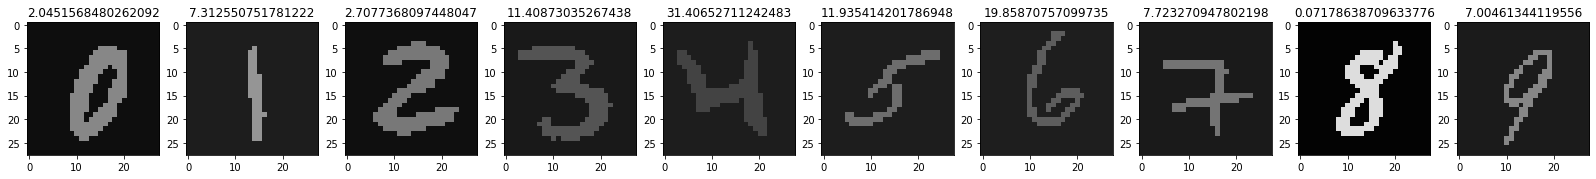

Result - 8


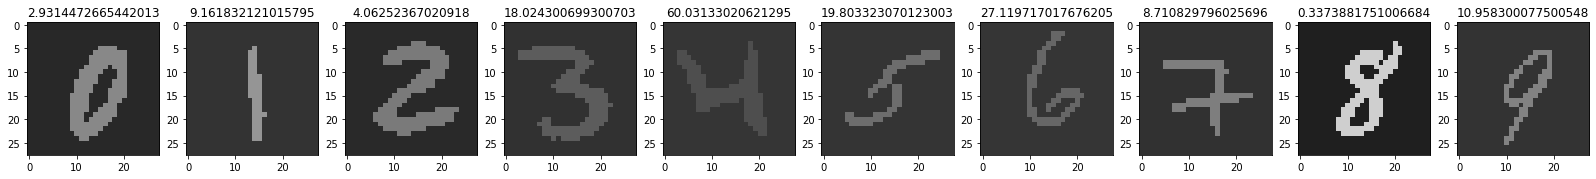

Result - 8


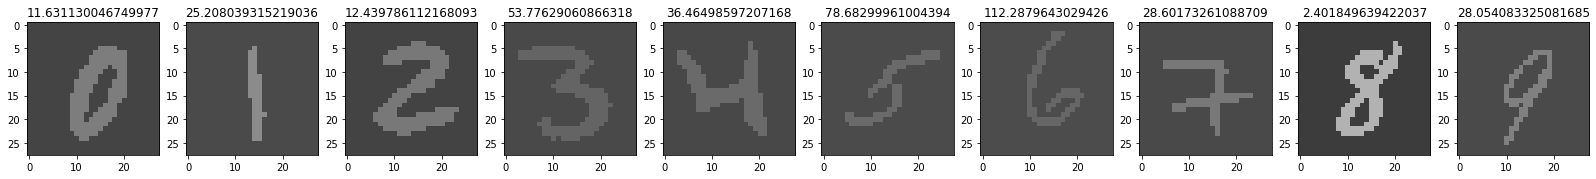

Result - 8


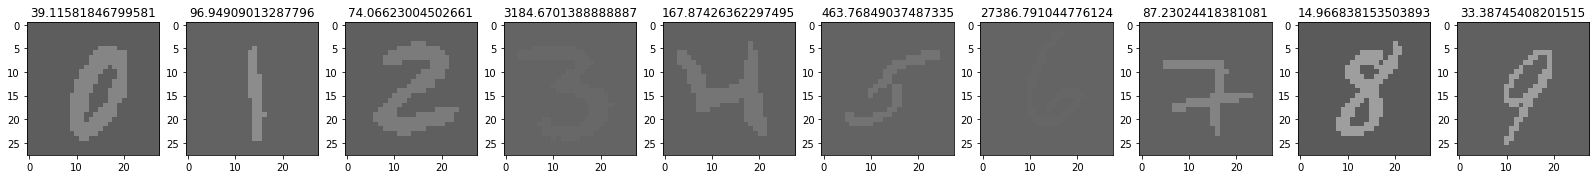

C:\Users\golev\AppData\Local\Temp\ipykernel_14988\2696972119.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  diff =  np.square(np.linalg.norm(diff1))/np.square(np.linalg.norm(diff2))


Result - 3


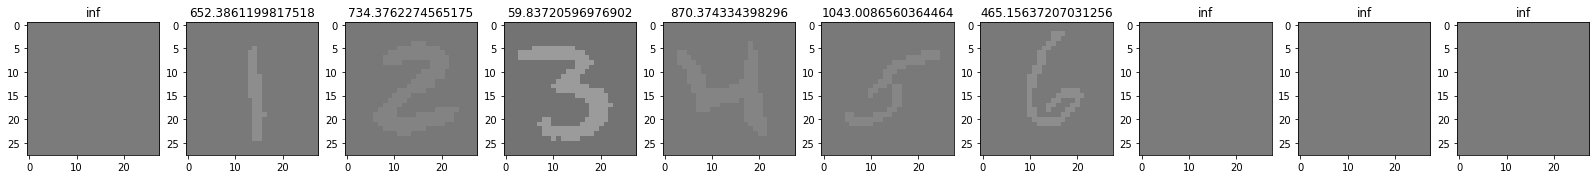

In [152]:
for image in noise_examples:
    result, imgs, diffs = findDigit(image, projection2)
    print(f'Result - {result}')
    showOneLine(imgs,[str(x) for x in diffs], dim = 10)


## Подсчеты ошибок с выборки

# Задание 5

**Варианты построения проекторов Πi:**
- После бинаризации изображений цифр Πi строятся как проекторы на формы изображений с двумя областями постоянной яркости **при сохранении той же упорядоченности неотрицательных яркостей областей, что и в эталонных изображениях (цифра светлее фона)**.
- Для генерации шума используется дискретное равномерное распределение сдвумя равновероятными значениями отклонений, σ и −σ.

Построить график зависимости частоты ошибок идентификации от корня дисперсии шума σ. 

Для наибольшей дисперсии шума также получить матрицу путаницы.

In [143]:
# g - image, f - masks
def projection2(g,f):
    p = g.copy()
    colors = []
    color1 = np.ma.array(g,mask=f).mean() #цвет цифры
    color2 = np.ma.array(g,mask=(255-f)).mean() #цвет фона

    if (color2>color1):
        p[f==0] = color1
        p[f==255] = color2
    else:
        p[::] =  g.mean()
        
    return p

In [133]:
sigmas = [0,100,150,175,187,200,210,215,220,225,230,235,240,245,250,255]

In [134]:
def calculation(projection):
    
   
    errors =  []
    confusion_matrix = np.zeros((10,10))
    # проходимся по каждому отклонению
    for sigma in sigmas:
        error = 0
        #по каждой цифре
        for digit, dig_img in enumerate(samples):
            # выборка 100 для каждой цифры
            for tmp_img in genNoises(dig_img, sigma, length = 100):
                # если ошиблись, считаем ошибку
                result = findDigit(tmp_img, projection)[0]
                
                if (sigma == 240):
                        confusion_matrix[digit,result]+=1
                        
                if digit != result:
                    error +=1
                    
        errors.append(error)
     

    errors = np.array(errors)
    return errors, confusion_matrix

In [135]:
errors1, confusion_matrix1 = calculation(projection)

C:\Users\golev\AppData\Local\Temp\ipykernel_14988\2696972119.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  diff =  np.square(np.linalg.norm(diff1))/np.square(np.linalg.norm(diff2))


In [145]:
errors2, confusion_matrix2 = calculation(projection2)

C:\Users\golev\AppData\Local\Temp\ipykernel_14988\2696972119.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  diff =  np.square(np.linalg.norm(diff1))/np.square(np.linalg.norm(diff2))


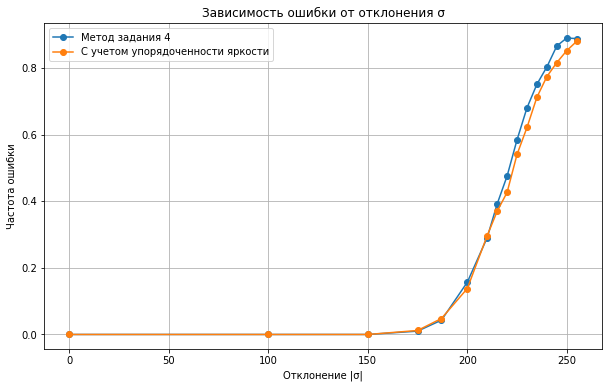

In [146]:
plt.figure(figsize=(10, 6))
plt.plot(sigmas, errors1/1000, marker='o', linestyle='-',label="Метод задания 4")
plt.plot(sigmas, errors2/1000, marker='o', linestyle='-',label="С учетом упорядоченности яркости")
plt.xlabel('Отклонение |σ|')
plt.ylabel('Частота ошибки')
plt.title('Зависимость ошибки от отклонения σ')
plt.legend()
plt.grid(True)
plt.show()

In [138]:
def colorized(confusion_matrix, ax):
    alpha = [str(x) for x in range(10)]
    xaxis = np.arange(len(alpha))
    ax.matshow(confusion_matrix/100, cmap=plt.cm.Blues)
    ax.set_xticks(xaxis)
    ax.set_yticks(xaxis)
    ax.set_xticklabels(alpha)
    ax.set_yticklabels(alpha)
    for i in range(10):
        for j in range(10):
            c = confusion_matrix[j,i]/100
            ax.text(i, j, str(c), va='center', ha='center')

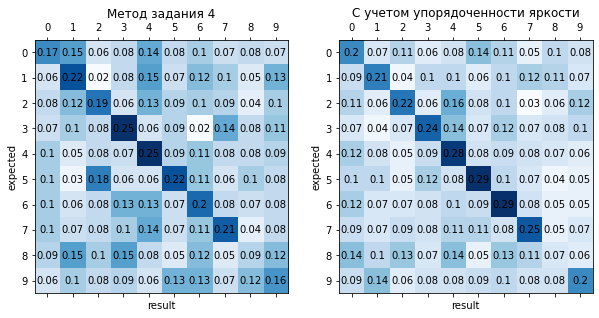

In [148]:
plt.figure(figsize=(10, 6))
text = ['Метод задания 4', 'С учетом упорядоченности яркости']
for i in range(2):
    ax =plt.subplot(1, 2, i+1)
    plt.title(text[i])
    plt.xlabel('result')

    plt.ylabel('expected')

    colorized([confusion_matrix1,confusion_matrix2][i], ax)
    

   